In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import torchvision.transforms as T
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

from torchdiffeq import odeint

from neuralop.models import FNO2d, FNO

from ndo_utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
cnn = SimpleConvNet().to(device=device)
cnn.load_state_dict(torch.load('./data/inverse_heat_cnn.pth'))

<All keys matched successfully>

In [3]:
fno = FNO2d(
    in_channels=1,
    out_channels=1,
    n_modes_width=16,
    n_modes_height=16,
    hidden_channels=32,
).to(device=device)

fno.load_state_dict(torch.load('./data/inverse_heat_fno.pth', weights_only=False))
fno.eval()

FNO2d(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
          (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 1, kernel_size

In [4]:
ndo = InverseHeatNDO(modes=(16,16), hidden_channels=32, atol=1e-5, rtol=1e-5).to(device=device)

state_dict = torch.load('./data/inverse_heat_ndo.pth', weights_only=False)

if '_metadata' in state_dict:
    del state_dict['_metadata']

ndo.load_state_dict(state_dict)
ndo.eval()

InverseHeatNDO(
  (fno): FNO2d(
    (positional_embedding): GridEmbeddingND()
    (fno_blocks): FNOBlocks(
      (convs): ModuleList(
        (0-3): 4 x SpectralConv(
          (weight): DenseTensor(shape=torch.Size([32, 32, 16, 9]), rank=None)
        )
      )
      (fno_skips): ModuleList(
        (0-3): 4 x Flattened1dConv(
          (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
      )
      (channel_mlp): ModuleList(
        (0-3): 4 x ChannelMLP(
          (fcs): ModuleList(
            (0): Conv1d(32, 16, kernel_size=(1,), stride=(1,))
            (1): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
          )
        )
      )
      (channel_mlp_skips): ModuleList(
        (0-3): 4 x SoftGating()
      )
    )
    (lifting): ChannelMLP(
      (fcs): ModuleList(
        (0): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
        (1): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
      )
    )
    (projection): ChannelMLP(
      (fcs): ModuleList(
    

In [5]:
data_test = torch.load('./data/heat_dataset_test.pt')
u0_test = data_test['u0']
ut_final_test = data_test['ut_final']


u0_test = u0_test.unsqueeze(1).to(device)
ut_final_test = ut_final_test.unsqueeze(1).to(device)

In [6]:
CNN_sols = []
FNO_sols = []
NDO_sols = []

with torch.no_grad():

    noise_0 = torch.randn_like(ut_final_test[0, ...].unsqueeze(0))

    for ii in range(0, 101):

        noise_level = ii / 400.0

        print(f'Processing noise level: {noise_level}')

        noise = noise_0 * noise_level * torch.norm(ut_final_test[0, ...].unsqueeze(0), p=2, dim=(1,2,3), keepdim=True) / torch.norm(noise_0, p=2, dim=(1,2,3), keepdim=True)

        CNN_sol = ut_final_test[0, ...].unsqueeze(0) + noise
        FNO_sol = ut_final_test[0, ...].unsqueeze(0) + noise

        for ii in range(0, 201):
            CNN_sol = cnn(CNN_sol)
            FNO_sol = fno(FNO_sol)

        CNN_sols.append(CNN_sol.detach().cpu().squeeze([1,2]).numpy())
        FNO_sols.append(FNO_sol.detach().cpu().squeeze([1,2]).numpy())
        NDO_sol = ndo(ut_final_test[0, ...].unsqueeze(0) + noise, s_span=torch.Tensor([0,1])).detach().cpu().squeeze([1,2])[-1].numpy()
        NDO_sols.append(NDO_sol)

        

Processing noise level: 0.0


c:\Users\conno\assignments\UW\amath_575\575_project\virt\Lib\site-packages\torchdiffeq\_impl\misc.py:306: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")


Processing noise level: 0.0025
Processing noise level: 0.005
Processing noise level: 0.0075
Processing noise level: 0.01
Processing noise level: 0.0125
Processing noise level: 0.015
Processing noise level: 0.0175
Processing noise level: 0.02
Processing noise level: 0.0225
Processing noise level: 0.025
Processing noise level: 0.0275
Processing noise level: 0.03
Processing noise level: 0.0325
Processing noise level: 0.035
Processing noise level: 0.0375
Processing noise level: 0.04
Processing noise level: 0.0425
Processing noise level: 0.045
Processing noise level: 0.0475
Processing noise level: 0.05
Processing noise level: 0.0525
Processing noise level: 0.055
Processing noise level: 0.0575
Processing noise level: 0.06
Processing noise level: 0.0625
Processing noise level: 0.065
Processing noise level: 0.0675
Processing noise level: 0.07
Processing noise level: 0.0725
Processing noise level: 0.075
Processing noise level: 0.0775
Processing noise level: 0.08
Processing noise level: 0.0825
P

In [7]:
true_sol = u0_test[0, ...].detach().cpu().squeeze([0,1]).numpy()

errors_CNN = np.array([np.linalg.norm(true_sol - CNN_sol) for CNN_sol in CNN_sols])
errors_FNO = np.array([np.linalg.norm(true_sol - FNO_sol) for FNO_sol in FNO_sols]) 
errors_NDO = np.array([np.linalg.norm(true_sol - NDO_sol) for NDO_sol in NDO_sols])

RRE_CNN = errors_CNN / np.linalg.norm(true_sol)
RRE_FNO = errors_FNO / np.linalg.norm(true_sol)
RRE_NDO = errors_NDO / np.linalg.norm(true_sol)

In [8]:
noise_span = np.linspace(0, 0.25, 101)
n_frames = 101 
import matplotlib.animation as animation

plt.style.use('dark_background')

c:\Users\conno\assignments\UW\amath_575\575_project\virt\Lib\site-packages\matplotlib\colors.py:778: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


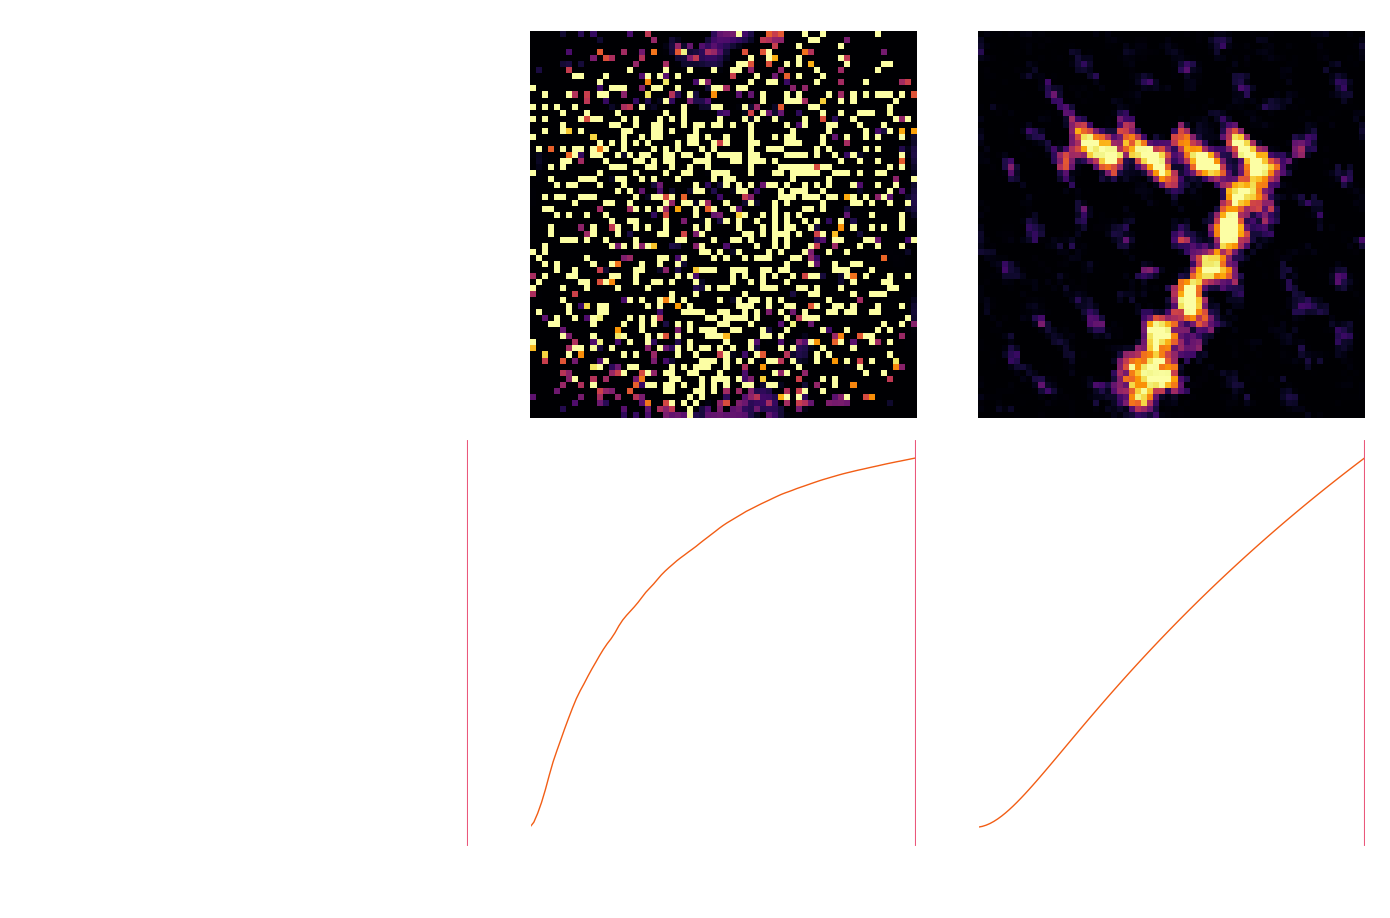

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(14, 9.3))
ax_img_cnn, ax_img_fno, ax_img_ndo = axes[0]
ax_err_cnn, ax_err_fno, ax_err_ndo = axes[1]

fig.set_facecolor('none')

for ax in axes[0]:
    ax.set_facecolor('none')
for ax in axes[1]:
    ax.set_facecolor('none')


ax_img_cnn.set_title("CNN")
ax_img_fno.set_title("FNO")
ax_img_ndo.set_title("NDO")


im_cnn = ax_img_cnn.imshow(CNN_sols[0][0,...], cmap='inferno', vmin=0, vmax=1, animated=True)
im_fno = ax_img_fno.imshow(FNO_sols[0][0,...], cmap='inferno', vmin=0, vmax=1, animated=True)
im_ndo = ax_img_ndo.imshow(NDO_sols[0], cmap='inferno', vmin=0, vmax=1, animated=True)

for ax in (ax_img_cnn, ax_img_fno, ax_img_ndo):
    ax.axis('off')


line_cnn, = ax_err_cnn.plot(noise_span, RRE_CNN, lw=1, color='#f25e16', animated=True)
line_fno, = ax_err_fno.plot(noise_span, RRE_FNO, lw=1, color='#f25e16', animated=True)
line_ndo, = ax_err_ndo.plot(noise_span, RRE_NDO, lw=1, color='#f25e16', animated=True)


vline_cnn = ax_err_cnn.axvline(0, color='#e94f74', animated=True)
vline_fno = ax_err_fno.axvline(0, color='#e94f74', animated=True)
vline_ndo = ax_err_ndo.axvline(0, color='#e94f74', animated=True)


ax_err_cnn.set_ylabel("relative reconstruction error")
for ax in (ax_err_cnn, ax_err_fno, ax_err_ndo):
    ax.set_xlim(0, noise_span[-1])


fig.supxlabel("noise level")

plt.tight_layout()

def update(frame):
    im_cnn.set_data(CNN_sols[frame][0,...])
    im_fno.set_data(FNO_sols[frame][0,...])
    im_ndo.set_data(NDO_sols[frame])

    xpos = noise_span[frame]

    vline_cnn.set_xdata([xpos, xpos])
    vline_fno.set_xdata([xpos, xpos])
    vline_ndo.set_xdata([xpos, xpos])
    return (im_cnn, im_fno, im_ndo, vline_cnn, vline_fno, vline_ndo)

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=60, blit=True)


ani.save('./im/noise_sweep.png', writer=animation.PillowWriter(fps=15))